### Build env for this notebook (temp. fix):

Running this on CPU with different environment, as tensorflow does not support 5000-series Nvidia GPUs yet

```
conda create -n dnn_cpu python=3.12
conda activate dnn_cpu
conda install numpy pandas=2.2.3 scikit-learn seaborn ipykernel networkx
pip install tensorflow-cpu
pip install -e .
```

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
)
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

import seaborn as sns
from subpred.evaluation import plot_results_long
from subpred.util import save_results, load_data
import random
import pickle

2025-06-06 03:28:23.583322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 03:28:23.621862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-06 03:28:24.920177: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)  # this is a starting seed. notebook needs to be restarted to get same results. random number generation might change with future versions of tf

In [3]:
# importing feature data from SVM notebooks (they have to be run first)
import pickle
with open("../data/tmp_data/svc_at_sugaramino_ml_data.pickle", "rb") as handle:
    ml_datasets = pickle.load(handle)
# with open("../data/tmp_data/svc_at_sugaramino_outlier_removal_ml_data.pickle", "rb") as handle:
#     ml_datasets_filtered = pickle.load(handle)

In [4]:
ml_datasets[12]

Name: PROSTT5_3DI, Features: 1024, Samples: 54, Classes: [0 1], Labels: ['amino acid transmembrane transporter activity'
 'sugar transmembrane transporter activity'])

In [5]:
from tensorflow import keras

# Test result AT sugar amino: the three models perform very similarly, just use the simplest one (create_model)
# Tried different values for dropout (0.0,0.3,0.5,0.7), performance for non-0 is similar.
# Dropout 0.5 for smaller datasets, maybe try 0.3 for larger
# Tried different values for batch_size. Not really a big difference. 8 for smaller, 16 or 32 for larger
# TODO put this code into subpred package, when TF is compatible with new GPU

def create_model(n_features):
    # Larger datasets: try lower dropout
    # Try starting at lower number of nodes
    model = keras.Sequential(
        [
            keras.layers.Input(shape=(n_features,)),
            keras.layers.Dense(512, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(average="macro", name="F1_macro"),
            keras.metrics.TruePositives(name="TP"),
            keras.metrics.TrueNegatives(name="TN"),
            keras.metrics.FalsePositives(name="FP"),
            keras.metrics.FalseNegatives(name="FN"),
        ],
    )
    return model


def create_model_dynamic_nodes(n_features):
    if n_features > 1024:
        layer_sizes = [1024, 512, 256]
        print("selecting large model")
    elif n_features > 512:  # includes embeddings with len 1024
        layer_sizes = [512, 256, 128]
        print("selecting medium model")
    else:
        layer_sizes = [256, 128, 64]
        print("selecting small model")
    model = keras.Sequential(
        [
            keras.layers.Input(shape=(n_features,)),
            keras.layers.Dense(layer_sizes[0], activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(layer_sizes[1], activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(layer_sizes[2], activation="relu"),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(average="macro", name="F1_macro"),
            keras.metrics.TruePositives(name="TP"),
            keras.metrics.TrueNegatives(name="TN"),
            keras.metrics.FalsePositives(name="FP"),
            keras.metrics.FalseNegatives(name="FN"),
        ],
    )
    return model


def create_model_dynamic_layers(n_features):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n_features,)))
    for layer_size in [2048, 1024, 512, 256]:
        if n_features >= layer_size:
            model.add(keras.layers.Dense(layer_size, activation="relu"))
            model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(average="macro", name="F1_macro"),
            keras.metrics.TruePositives(name="TP"),
            keras.metrics.TrueNegatives(name="TN"),
            keras.metrics.FalsePositives(name="FP"),
            keras.metrics.FalseNegatives(name="FN"),
        ],
    )

    return model

In [6]:
def crossval_dnn(
    ml_dataset,
    model_func,
    scores_dict,
    splits=5,
    repeats=5,
    epochs=100,
    batch_size=8,
    verbose=False,
):
    print(f"=== {ml_dataset.name} ===")
    preprocess = make_pipeline(VarianceThreshold(0.0), StandardScaler())

    X, y = ml_dataset.X, ml_dataset.y

    train_scores = list()
    test_scores = list()
    fold_count = 1
    for train_idx_outer, val_idx_outer in RepeatedStratifiedKFold(
        n_splits=splits, n_repeats=repeats, random_state=0
    ).split(X, y):
        if verbose:
            print(f"Fold {fold_count} out of {splits*repeats}")
        fold_count += 1

        X_train, X_test = X[train_idx_outer], X[val_idx_outer]
        y_train, y_test = y[train_idx_outer], y[val_idx_outer]

        X_train = preprocess.fit_transform(X_train, y_train)
        X_test = preprocess.transform(X_test)

        # important: create from scratch to reset weights
        model = model_func(X_train.shape[1])
        training_history = model.fit( # TODO class weights option
            X_train,
            y_train.reshape(-1, 1),
            epochs=epochs,
            batch_size=batch_size,
            verbose="auto" if verbose else 0,
        )
        y_prob = model.predict(X_test, verbose="auto" if verbose else 0)
        y_pred = (y_prob > 0.5).astype(int).flatten()
        # TODO log mis-classified samples: always the same ones?

        for score_name, score_func in scores_dict.items():
            test_scores.append(
                (ml_dataset.name, score_name, score_func(y_test, y_pred))
            )
            if verbose:
                print(score_name, score_func(y_test, y_pred))

        res = model.evaluate(
            X_test, y_test.reshape(-1, 1), verbose="auto" if verbose else 0
        )
        if verbose:
            print(res)
    df_scores = pd.DataFrame(test_scores, columns=["Feature", "Metric", "Value"])

    return df_scores

In [7]:
for pos, ml_dataset in enumerate(ml_datasets):
    print(pos, ml_dataset.name, len(ml_dataset.feature_names))

# removing features with less than 400 positions
ml_datasets = [
    ml_dataset for ml_dataset in ml_datasets if len(ml_dataset.feature_names) >= 400
]
feature_names = [ml_dataset.name for ml_dataset in ml_datasets]

0 DUMMY 1024
1 AAC 20
2 PAAC 400
3 AA_KMER3 8000
4 3Di_COMP 20
5 3Di_KMER2 400
6 3Di_KMER3 8000
7 COMB_KMER1 40
8 COMB_KMER2 800
9 COMB_KMER3 16000
10 PROTT5_AA 1024
11 PROSTT5_AA 1024
12 PROSTT5_3DI 1024
13 PSSM_50_1 400
14 PSSM_50_3 400
15 PSSM_90_1 400
16 PSSM_90_3 400
17 PSSM_META 1600
18 META 2020
19 META_STD 2020


In [8]:
scoring_outer = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Macro": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, average="macro"
    ),
    "F1 Amino Acid": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=0
    ),
    "F1 Sugar": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=1
    ),
}


In [ ]:


# TODO test all three models with different values for dropout, learning rate, epochs and batch size. then select the best model
# TODO mention this uses the same random state and data as svm cv splitter.

# TODO repeat everything for filtered dataset with no outliers
# TODO epochs. Early Stopping
# TODO smaller models, with fewer nodes per layer?


TEST_NAME = f"at_sugaramino_dnn"
from pathlib import Path
if Path(f"../data/results/{TEST_NAME}.pickle").exists():
    df_results_all = load_data(TEST_NAME, folder_path="../data/results")
else:
    results = [
        crossval_dnn(
            ml_dataset=ml_dataset,
            model_func=create_model,
            scores_dict=scoring_outer,
            splits=5,
            repeats=5,
            epochs=50,
            batch_size=16,
        )
        for ml_dataset in ml_datasets
    ]
    df_results_all = pd.concat(results)
        
#     for test_name, df_results in results_dfs:   
#         save_results(df_results,test_name)
# else:
#     results_dfs = [
#         (
#             f"at_sugaramino_dnn_2_{model_func.__name__}",  # TODO _2_
#             load_data(
#                 f"at_sugaramino_dnn_2_{model_func.__name__}", folder_path="../data/results"
#             ),
#         )
#         for model_func in model_funcs
#     ]

=== DUMMY ===
=== PAAC ===
=== AA_KMER3 ===
=== 3Di_KMER2 ===
=== 3Di_KMER3 ===
=== COMB_KMER2 ===
=== COMB_KMER3 ===
=== PROTT5_AA ===
=== PROSTT5_AA ===
=== PROSTT5_3DI ===
=== PSSM_50_1 ===
=== PSSM_50_3 ===
=== PSSM_90_1 ===
=== PSSM_90_3 ===
=== PSSM_META ===
=== META ===
=== META_STD ===


In [18]:
save_results(df_results_all,TEST_NAME)

In [20]:
[ml_dataset.name for ml_dataset in ml_datasets]


['DUMMY',
 'PAAC',
 'AA_KMER3',
 '3Di_KMER2',
 '3Di_KMER3',
 'COMB_KMER2',
 'COMB_KMER3',
 'PROTT5_AA',
 'PROSTT5_AA',
 'PROSTT5_3DI',
 'PSSM_50_1',
 'PSSM_50_3',
 'PSSM_90_1',
 'PSSM_90_3',
 'PSSM_META',
 'META',
 'META_STD']

In [ ]:
# TODO clean up x axis
# TODO table

df_results_plot = df_results_all.copy()
df_results_plot.Feature = df_results_plot.Feature.str.replace("_","-")

0        DUMMY
1        DUMMY
2        DUMMY
3        DUMMY
4        DUMMY
        ...   
95    META_STD
96    META_STD
97    META_STD
98    META_STD
99    META_STD
Name: Feature, Length: 1700, dtype: object

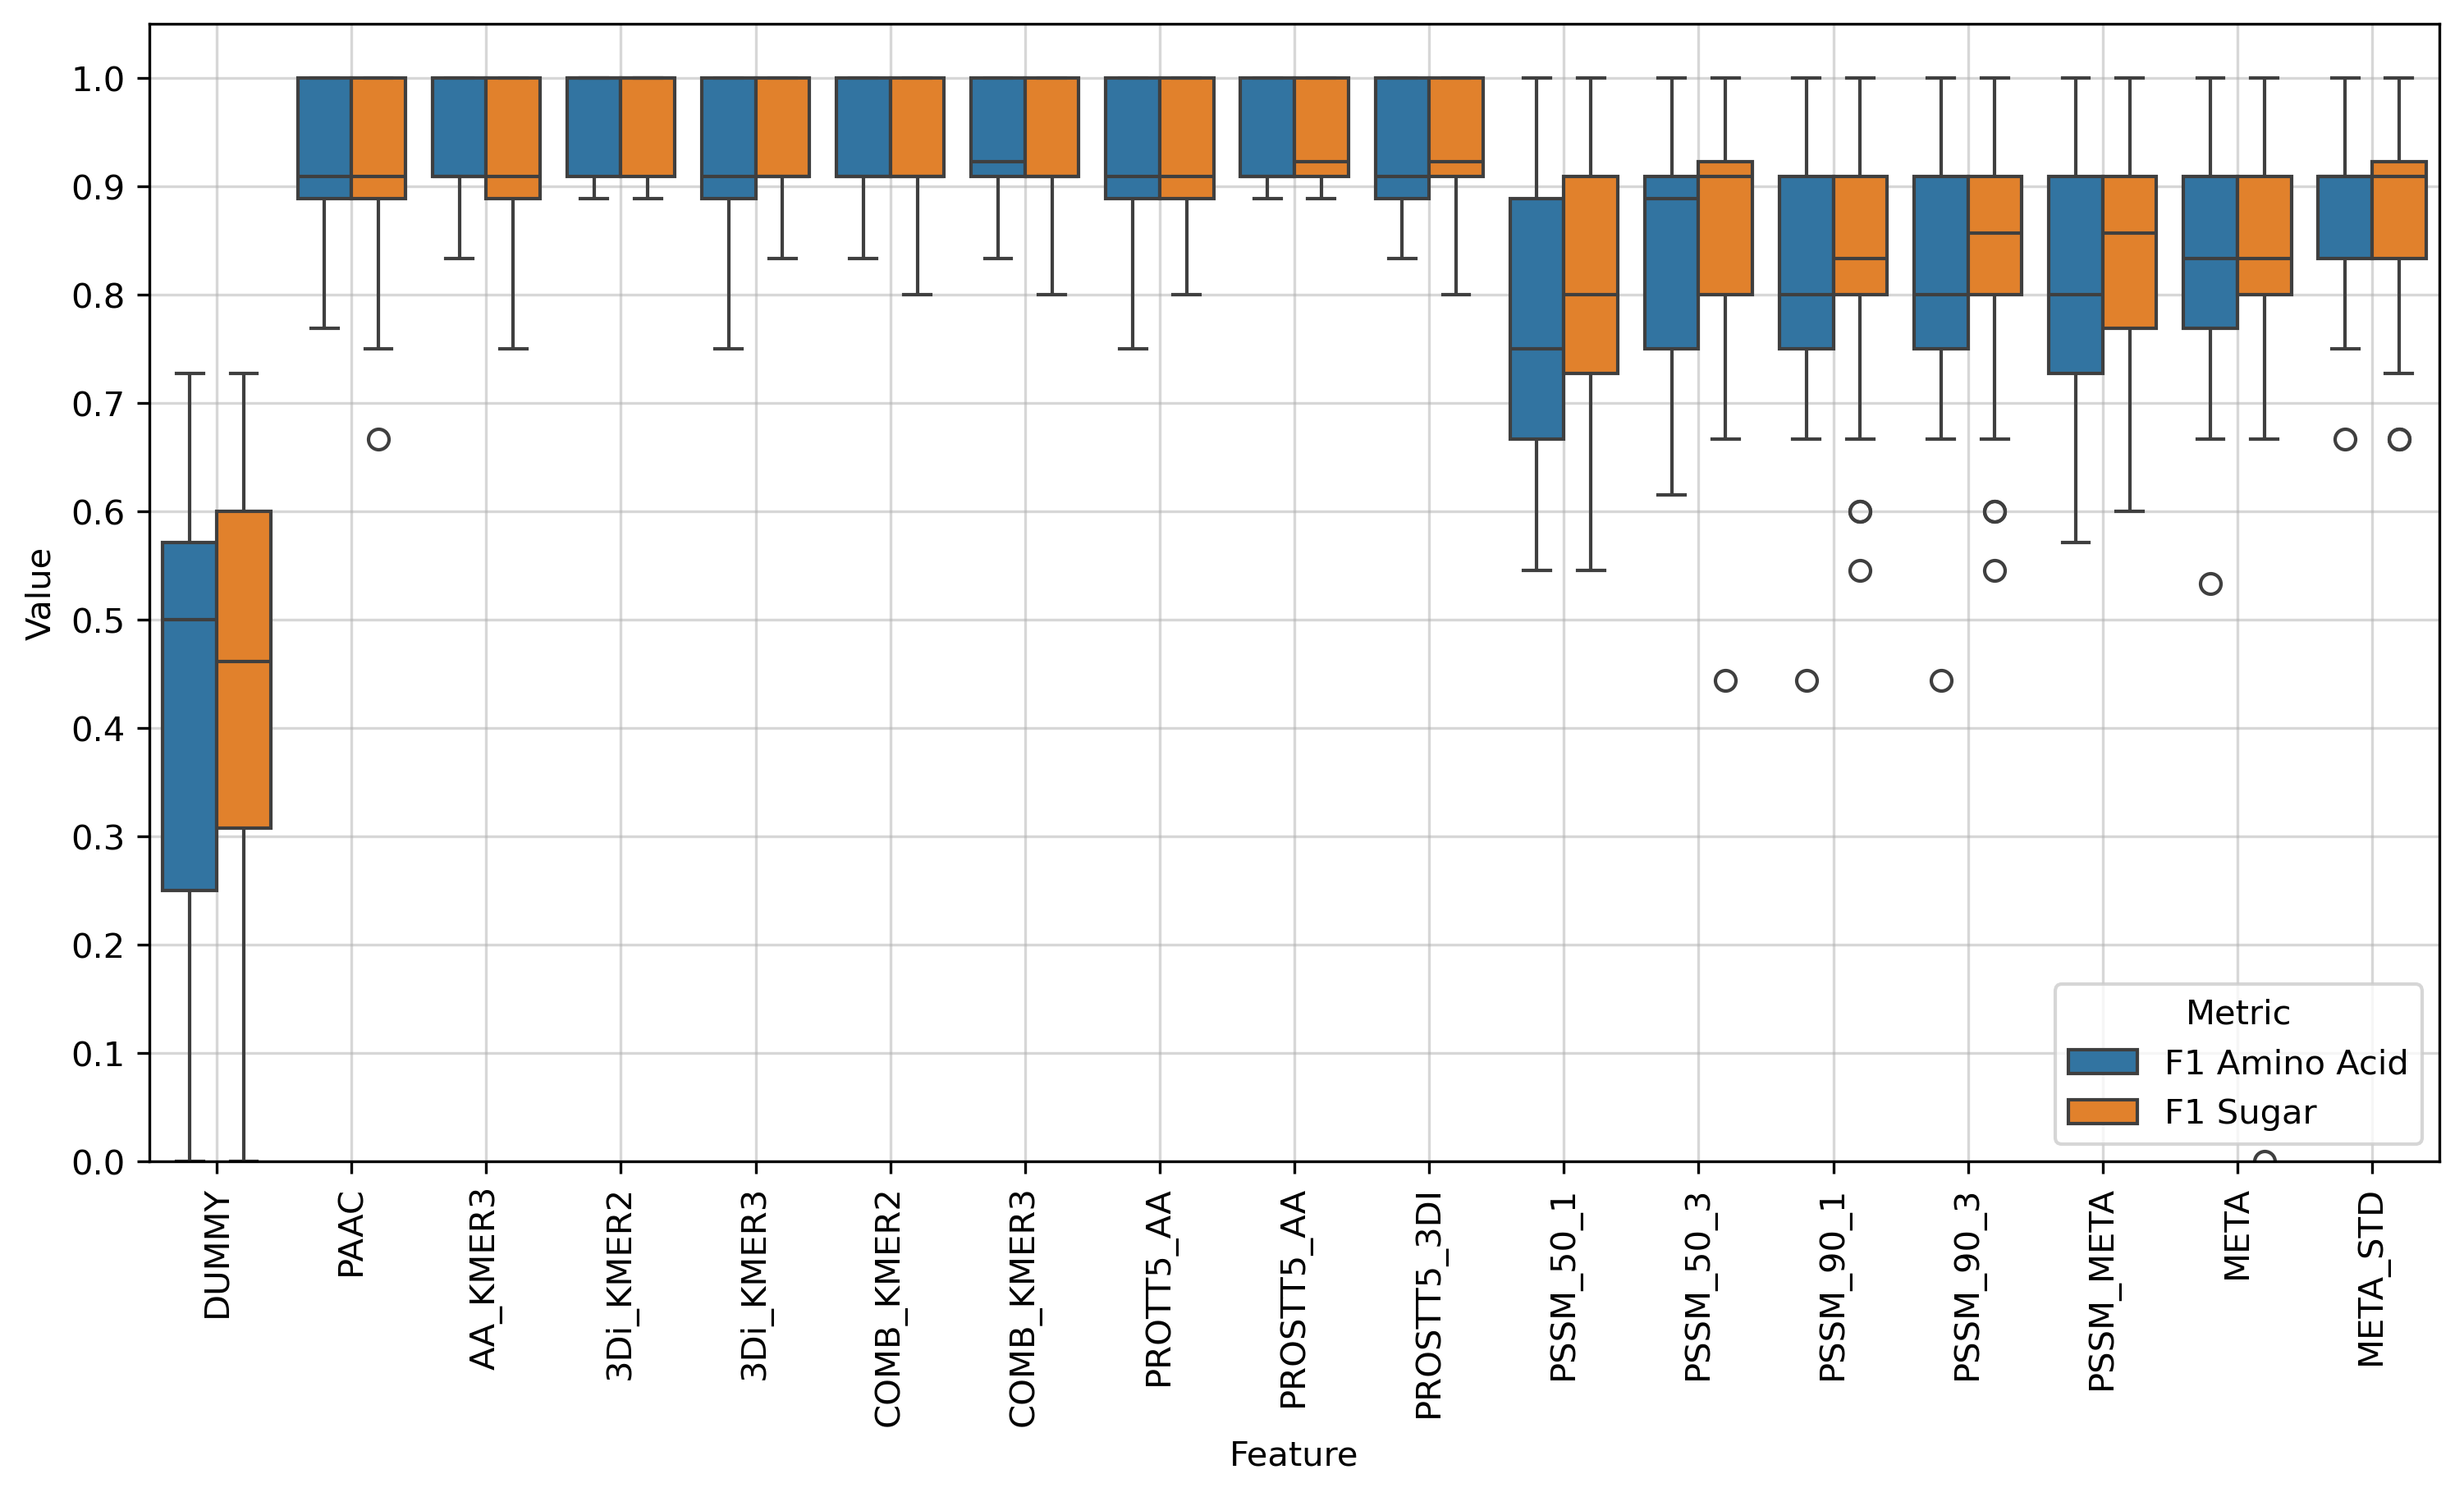

In [19]:
plot_results_long(
    df_results_long=df_results_all,
    output_folder_path="../data/results/",
    test_name=TEST_NAME,
    plot_order=feature_names,
    metrics_include=["F1 Amino Acid", "F1 Sugar"],
)